In [1]:
import numpy as np
import torch as th 
import matplotlib.pyplot as plt
from sbi.inference import NLE
from sbi.utils import BoxUniform
from sbi.inference.posteriors.ensemble_posterior import EnsemblePosterior
from sbi.utils.simulation_utils import simulate_for_sbi
from sbi.inference import MCABC
from sbibm.metrics import c2st
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator
)
from emnets.simulator import gaussian_simulator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_posterior_samples(prior, simulator, observation, n_samples=10000):
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator = process_simulator(simulator, prior, prior_returns_numpy)
    check_sbi_inputs(simulator, prior)
    inference_method = MCABC(
        simulator=simulator,
        prior=prior,
        show_progress_bars=False,
    )
    output, _ = inference_method(
        x_o=observation,
        num_simulations=n_samples*100,
        quantile=.01,
        return_summary=True
    )
    return output

In [3]:
# set experiments parameters
obs = th.tensor([3])
n_sims_init = 10000
n_samples = 5000
# set prior
prior = BoxUniform(low=-8 * th.ones(1), high=8 * th.ones(1))

In [4]:
# validate prior and simulator for sbi 
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(gaussian_simulator, prior, prior_returns_numpy)
# use mcmc for ground truth posterior samples 
mcmc_samples = get_posterior_samples(prior, gaussian_simulator, obs, n_samples=n_samples)
# simulate full dataset
theta, x = simulate_for_sbi(simulator, prior, num_simulations=n_sims_init, show_progress_bar=False)    

In [5]:
inference = NLE(prior=prior, density_estimator='made')
density_estimator = inference.append_simulations(theta, x).train(show_train_summary=False)
# generate posterior samples
posterior = inference.build_posterior(density_estimator)
nle_samples = posterior.sample((n_samples,), x=obs, show_progress_bars=False)
# compare MCMC with NLE w/ C2ST
c2st(nle_samples, mcmc_samples).item()

 Neural network successfully converged after 62 epochs.

/Users/hayden/miniconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


0.5146999955177307

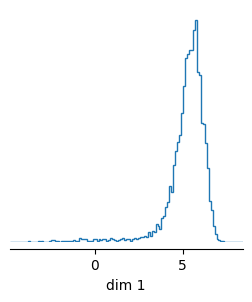

In [6]:
from sbi.analysis import pairplot

pairplot(mcmc_samples, figsize=(3,3))

plt.show()

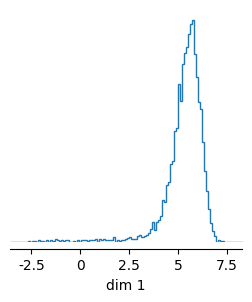

In [7]:
pairplot(nle_samples, figsize=(3,3))

plt.show()

In [63]:
with th.no_grad():
    y = inference._neural_net.forward(theta)

y

NotImplementedError: Module [NFlowsFlow] is missing the required "forward" function

In [65]:
inference._neural_net

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): IdentityTransform()
      )
    )
    (_distribution): MultivariateGaussianMDN(
      (_hidden_net): Sequential(
        (0): Linear(in_features=1, out_features=50, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=50, out_features=50, bias=True)
        (4): ReLU()
        (5): Linear(in_features=50, out_features=50, bias=True)
        (6): ReLU()
      )
      (_logits_layer): Linear(in_features=50, out_features=10, bias=True)
      (_means_layer): Linear(in_features=50, out_features=10, bias=True)
      (_unconstrained_diagonal_layer): Linear(in_features=50, out_features=10, bias=True)
      (_upper_layer): Linear(in_features=50, out_features=0, bias=True)
    )
    (_embedding_net): Sequential(
      (0): Standardize()
      (1): Identity()
    )
  )
)

In [9]:
inference = NLE(prior=prior, density_estimator='made')
inference._neural_net

In [10]:
inference._neural_net